In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [469]:
from pathlib import Path
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd
import modin.pandas
import geopandas as geopd
import networkx as nx
from infomap import Infomap
import community
import ray
import src.data.bin as data_bin
import src.data.read as read_data
import src.data.clustering as data_clustering
import src.data.word_counts as word_counts
import src.utils.parallel as parallel
import src.visualization.maps as map_viz
import src.visualization.interactive as interact_viz
import src.visualization.eval as eval_viz
from dotenv import load_dotenv
load_dotenv()

True

tf idf in data pre-processing? this way frequency is weighted so that "important" words are higher. But "document" definition? All tweets of a user maybe? ANd corpus = all tweets? Are words important for a dialect relevant in the tf idf sense?!

# Config

In [93]:
proj_data_path = Path('..', 'data').resolve()
freq_data_path = proj_data_path / 'raw' / 'freq'
freq_file_format = freq_data_path / '{0}_freq.dat'
shp_file_format = proj_data_path / 'external' / '{0}' / '{0}.shp'
processed_data_path = proj_data_path / 'processed'
figs_path = Path('..', 'reports', 'figures')
OSLOM_DIR = Path(os.environ['OSLOM_DIR'])
min_nr_counties = 3
cnt_count_th = 2e4
num_cpus = 8
xy_proj = 'ESRI:102005'
latlon_proj = 'epsg:4326'

In [91]:
fname_fmt = '{}_lang=en_cc=US.parquet'

# Load data

In [4]:
us_counties = geopd.read_file(str(shp_file_format).format('cb_2018_us_county_5m'))
us_states = geopd.read_file(str(shp_file_format).format('cb_2018_us_state_5m'))
us_states = us_states.astype({'STATEFP': int}).set_index('STATEFP')
us_counties = us_counties.astype({'GEOID': int, 'STATEFP': int})
# Exclude all overseas islands and Alaska
# to_exclude = (us_counties['STATEFP'].isin((15, 2))) | (us_counties['STATEFP'] > 56)
# us_counties = us_counties.loc[~to_exclude]
us_counties = us_counties.set_index('GEOID').join(us_states['NAME'], on='STATEFP', rsuffix='_STATE')
us_counties.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID      NAME LSAD       ALAND  \
GEOID                                                                          
39071       39      071  01074048  0500000US39071  Highland   06  1432479992   
6003         6      003  01675840  0500000US06003    Alpine   06  1912292630   
12033       12      033  00295737  0500000US12033  Escambia   06  1701544502   
17101       17      101  00424252  0500000US17101  Lawrence   06   963936864   
28153       28      153  00695797  0500000US28153     Wayne   06  2099745573   

          AWATER                                           geometry  \
GEOID                                                                 
39071   12194983  POLYGON ((-83.86976 39.05553, -83.86568 39.247...   
6003    12557304  POLYGON ((-120.07248 38.50987, -120.07239 38.7...   
12033  563927612  POLYGON ((-87.62999 30.87766, -87.62946 30.880...   
17101    5077783  POLYGON ((-87.91028 38.57493, -87.90811 38.850...   
28153    7255476  POLYGON ((-88.94317 31.78421, -88.94335 31.824...   

        NAME_STATE  
GEOID               
39071         Ohio  
6003    California  
12033      Florida  
17101     Illinois  
28153  Mississippi

There are some files whose extracted FIPS don't correspond to any real county

In [5]:
fips_list = []
pattern = re.compile(freq_file_format.name.format('([0-9]{4,5})'))
for f in freq_file_format.parent.iterdir():
    match = re.search(pattern, f.name)
    if match:
        fips_list.append(int(match.group(1)))
has_data = us_counties.index.intersection(fips_list)
nr_counties = len(has_data)
print(nr_counties)

3074


In [ ]:
# # ray.init(num_cpus=num_cpus)
# get counties_dict and global_words
obj_refs = parallel.split_task(read_data.distribs_extract, num_cpus, us_counties.loc[has_data].index, freq_file_format)
res = ray.get(obj_refs)
global_words = res[0][0]
counties_dict = res[0][1]
for r in res[1:]:
    global_words = global_words.add(r[0], fill_value=0)
    counties_dict.update(r[1])
nr_counties_mask = global_words['nr_cells'] >= min_nr_counties
list_cell_counts = [word_counts.filter_part_multidx(r[2], [nr_counties_mask]) for r in res]
cell_counts = pd.concat(list_cell_counts).sort_index(axis=0, level=0)
global_words = global_words.astype(int).sort_values(ascending=False, by='count')
# del res
# ray.shutdown()

2 / 5126m(pid=61551) 1 / 512
2 / 5126m(pid=61551) 1 / 512
2 / 5126m(pid=61551) 1 / 512
2 / 5126m(pid=61551) 1 / 512
(pid=61552) 1 / 512
(pid=61552) 1 / 512
(pid=61552) 1 / 512
(pid=61552) 1 / 512
(pid=61550) 1 / 513
(pid=61550) 1 / 513
(pid=61550) 1 / 513
(pid=61550) 1 / 513
(pid=61551) 3 / 512
(pid=61551) 3 / 512
(pid=61551) 3 / 512
(pid=61551) 3 / 512
3 / 5126m(pid=61552) 2 / 512
3 / 5126m(pid=61552) 2 / 512
3 / 5126m(pid=61552) 2 / 512
3 / 5126m(pid=61552) 2 / 512
(pid=61550) 2 / 513
(pid=61550) 2 / 513
(pid=61550) 2 / 513
(pid=61550) 2 / 513
(pid=61550) 3 / 513
(pid=61550) 3 / 513
(pid=61550) 3 / 513
(pid=61550) 3 / 513
(pid=61551) 4 / 512
(pid=61551) 4 / 512
(pid=61551) 4 / 512
(pid=61551) 4 / 512
(pid=61551) 5 / 512
(pid=61551) 5 / 512
(pid=61551) 5 / 512
(pid=61551) 5 / 512
5 / 5136m(pid=61550) 4 / 513
5 / 5136m(pid=61550) 4 / 513
5 / 5136m(pid=61550) 4 / 513
5 / 5136m(pid=61550) 4 / 513
(pid=61551) 6 / 512
(pid=61551) 6 / 512
(pid=61551) 6 / 512
(pid=61551) 6 / 512
(pid=61550) 

In [246]:
cell_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('raw_cell_counts'), index=True)

In [136]:
cell_counts = pd.read_parquet(proj_data_path / 'raw' / fname_fmt.format('raw_cell_counts'))

In [244]:
reg_counts = (cell_counts.groupby('word')
                         .sum()
                         .sort_values(ascending=False, by='count')
                         .assign(count_upper=0))

In [247]:
filtered_cell_counts, reg_counts = word_counts.filter_cell_counts(
    cell_counts, reg_counts, cell_tokens_th=cnt_count_th)
valid_cnt = filtered_cell_counts.index.levels[filtered_cell_counts.index.names.index('cell_id')]
nr_counties = len(valid_cnt)
print(nr_counties)

2021-02-25 17:22:47,801	ERROR worker.py:1053 -- Possible unhandled error from worker: ray::remote_sbm() (pid=61553, ip=10.34.1.5)
  File "python/ray/_raylet.pyx", line 509, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 510, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1466, in ray._raylet.CoreWorker.store_task_outputs
  File "/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/ray/serialization.py", line 319, in serialize
    return self._serialize_to_msgpack(value)
  File "/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/ray/serialization.py", line 299, in _serialize_to_msgpack
    self._serialize_to_pickle5(metadata, python_objects)
  File "/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/ray/serialization.py", line 259, in _serialize_to_pickle5
    raise e
  File "/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/ray/serialization.py", line

We had 8469524673 tokens, and filtering brought it down to 8467928480, so we lost 0.0188%.
2925


In [431]:
filtered_cell_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('cell_counts'), index=True)

In [10]:
# Filter out desertic counties with not enough data
valid_cnt = []
for fips, cnt_dict in counties_dict.items():
    if cnt_dict['word_counts'].sum() > cnt_count_th:
        valid_cnt.append(fips)
nr_counties = len(valid_cnt)
print(nr_counties)

2925


In [11]:
global_words.astype(int).sort_values(ascending=False, by='count').to_csv(proj_data_path / 'interim' / 'usa_counts.csv')

wan and gon separated from na for some reason

# Detecting dialects

Pb: less represented words tend to have lesser values in diff_array, and the difference in the frequencies of the most frequent words don't really reflect dialect-related differences.

Pb of noise!! Remove outliers? Like words where one (or a few?) county has frequency orders of magnitude above mean/median.

power spectrum?

normalize variations of word frequencies: -1 to 1, with -1 or 1 corresponding to largest absolute difference with mean. This way most common words are not most important,  but maybe too egalitarian? also smoothes out huge variations in smaller counties. Meaningless words should display random variations, except in a few counties maybe -> variance is noise. For instance if very uncommon word which is orders of magnitude more present in a few scarcely populated counties,  these will have 1, and all the other a negative value very close to 0 -> very little variance (because a few / 3000), which PCA will not try to explain in the first components

In [395]:
from sklearn.decomposition import PCA
import sklearn.cluster
import scipy.cluster.hierarchy as shc

In [273]:
global_words = pd.read_csv(proj_data_path / 'interim' / 'usa_counts.csv', index_col=0, keep_default_na=False)
nr_counties_mask = global_words['nr_cells'] >= min_nr_counties
global_words = global_words.loc[nr_counties_mask].reset_index()
global_words.head()

word      count  nr_cells
0    i  387185896      3074
1  the  201617056      3074
2   to  195594819      3074
3  you  170160566      3073
4    a  152518189      3074

Because of the >5 in read, difference here

In [277]:
global_words['count'].sum()

8366723751

In [276]:
reg_counts['count'].sum()

8469524673

In [278]:
# Reindex word_counts with integers corresponding to the words
for cnt_dict in tqdm(counties_dict.values()):
    cnt_dict['word_counts'] = global_words[['word']].join(cnt_dict['word_counts'], on='word', how='inner')['count']

100%|██████████| 3074/3074 [13:54<00:00,  3.68it/s]


Building word_vectors:

In [442]:
cdf_mask = (reg_counts['count'] / reg_counts['count'].sum()).cumsum() < 0.99
word_counts_vectors = word_counts.to_vectors(filtered_cell_counts, cdf_mask)

In [449]:
word_vec_var = 'polar'
word_vectors = word_counts.vec_to_metric(word_counts_vectors,
                                         reg_counts.loc[cdf_mask],
                                         word_vec_var=word_vec_var)

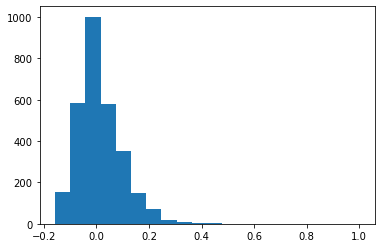

In [448]:
iloc_word = list(cdf_mask.loc[cdf_mask].index).index('anybody')
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(word_vectors[:, iloc_word], bins=20)

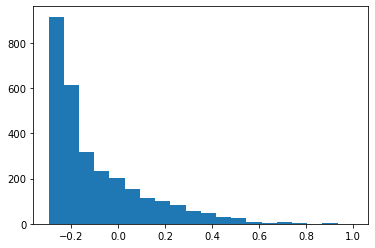

In [441]:
iloc_word = list(cdf_mask.loc[cdf_mask].index).index('nigga')
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(word_vectors[:, iloc_word], bins=20)

In [314]:
old_cdf_mask = (global_words['count'] / global_words['count'].sum()).cumsum() < 0.99
old_word_vectors = np.zeros((nr_counties, old_cdf_mask.sum()))

# for i, cnt_dict in enumerate(tqdm(counties_dict.values())):
for i, fips in enumerate(tqdm(valid_cnt)):
    cnt_counts = counties_dict[fips]['word_counts']
    # We keep only the words in the top 99% of CDF, and those of which are not
    # present in the county get attributed a null prop
    cnt_distrib_incl_missing = cnt_counts.reindex_like(global_words.loc[old_cdf_mask]).fillna(0).values
    cnt_distrib_incl_missing /= cnt_distrib_incl_missing.sum()
    old_word_vectors[i, :] = cnt_distrib_incl_missing

100%|██████████| 2925/2925 [00:20<00:00, 143.82it/s]


## Dissimilarity matrix (find regions then words)

In [63]:
n_components = 20
pca = PCA(n_components=n_components)
pca.fit(word_vectors)
proj_word_vectors = pca.transform(word_vectors)

In [194]:
pca.explained_variance_ratio_

array([0.05779782, 0.01830965, 0.01374718, 0.0098215 , 0.00644116,
       0.00566465, 0.00492107, 0.00460474, 0.00393996, 0.00344346])

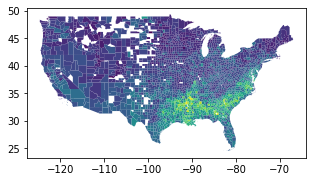

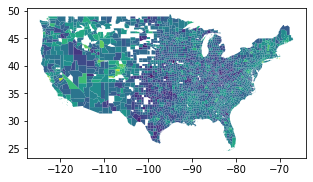

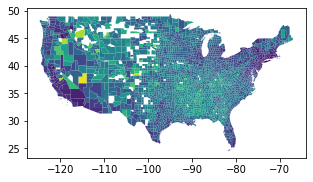

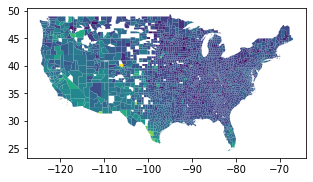

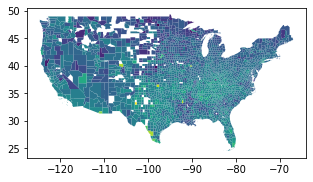

In [195]:
for i in range(n_components-5):
    fig, ax = plt.subplots(1, figsize=(5,3))
    proj_cnt = pd.Series(proj_word_vectors[:,i], index=valid_cnt, name='pca_comp')
    county_partition_df = us_counties[['geometry']].join(proj_cnt, how='inner')
    county_partition_df.to_crs('epsg:4326').plot(ax=ax, column='pca_comp')

In [347]:
linkage = shc.linkage(word_vectors, metric='cosine', method='complete') #ward

Cosine leads to majority of singleton clusters, no matter the linkage mehod

In [34]:
linkage = shc.linkage(proj_word_vectors, method='ward') #ward metric='cosine', 

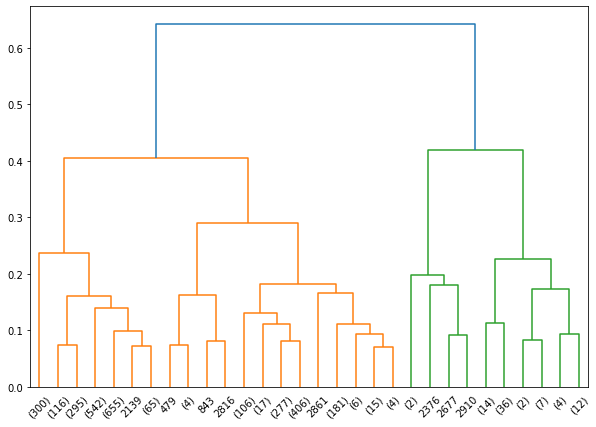

In [35]:
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

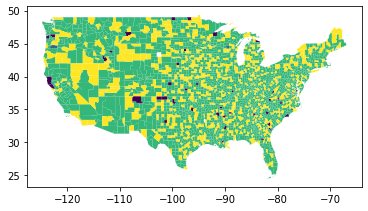

In [338]:
cnt_clusters = shc.fcluster(linkage, 4, criterion='maxclust')
hierarc_dict = {fips: cluster for fips, cluster in zip(fips_list, cnt_clusters)}
county_partition_df = us_counties[['geometry']].join(pd.Series(hierarc_dict, name='hierarc'), how='inner')
county_partition_df.plot(column='hierarc')

## Morans I into PCA into regionalization (find words then regions)

### Morans I

In [397]:
import libpysal
import esda

In [398]:
geodf = us_counties.loc[valid_cnt].to_crs(xy_proj)
contiguity = libpysal.weights.Queen.from_dataframe(geodf)
# contiguity = libpysal.weights.Kernel.from_dataframe(geodf, fixed=False, k=2, function='gaussian')
contiguity.transform = 'r'

('WARNING: ', 1155, ' is an island (no neighbors)')
('WARNING: ', 2766, ' is an island (no neighbors)')


/home/thomaslouf/Documents/code/words-use/.cenv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1155, 2766.



Only two islands, which are actual islands

In [404]:
num_cpus = 8
ray.init(num_cpus=num_cpus)
num_morans = word_vectors.shape[1]
shared_word_vectors = ray.put(word_vectors)
obj_refs = parallel.split_task(data_clustering.chunk_moran, num_cpus,
                               list(range(num_morans)), shared_word_vectors, contiguity)
res = ray.get(obj_refs)
moran_dict = res[0]
for m_dict in res[1:]:
    for key, value in m_dict.items():
        moran_dict[key].extend(value)
# ray.shutdown()

In [412]:
reg_counts = reg_counts.join(pd.DataFrame.from_dict(moran_dict).set_index(reg_counts.loc[cdf_mask].index[:num_morans]))
reg_counts.head()

count  count_upper  nr_cells  is_proper  nr_cell_mask         I  \
word                                                                        
i     387185896            0      3074      False          True  0.332156   
the   201617056            0      3074      False          True  0.437912   
to    195594819            0      3074      False          True  0.216122   
you   170160569            0      3074      False          True  0.253096   
a     152518189            0      3074      False          True  0.423665   

        z_value  p_value  
word                      
i     28.364444    0.001  
the   38.576611    0.001  
to    18.786063    0.001  
you   22.092010    0.001  
a     38.048987    0.001

In [418]:
reg_counts.to_parquet(proj_data_path / 'raw' / fname_fmt.format('region_counts'), index=True)

In [592]:
global_words = global_words.drop(columns=['I', 'p_value', 'z_value'])

In [16]:
global_words = global_words.join(pd.DataFrame.from_dict(moran_dict).set_index(global_words.loc[cdf_mask].index[:num_morans]))
global_words.head()

NameError: name 'moran_dict' is not defined

In [417]:
global_words.to_csv(proj_data_path / 'interim' / f'global_words_morans_{word_vec_var}.csv')

Simply read result

In [408]:
global_words = pd.read_csv(proj_data_path / 'interim' / f'global_words_morans_{word_vec_var}.csv', index_col=0)

In [455]:
is_regional = (reg_counts['z_value'] > 20) & (reg_counts['p_value'] < 0.01)
reg_word_vectors = word_vectors[:, is_regional.loc[cdf_mask].values].copy()
reg_word_vectors.shape

(2925, 3299)

In [260]:
global_words.loc[(global_words['p_value'] > 0.01)].sort_values(by='p_value').tail()

word  count  nr_counties         I   z_value  p_value
24688  horizontal   5169          273 -0.002129 -0.152064      0.5
18693       gregg   9156          355 -0.001805 -0.136486      0.5
18011      kombat   9891          390 -0.001031 -0.100317      0.5
17844      floppy  10049          423 -0.002401 -0.155942      0.5
8290     comedian  40777          854 -0.000607 -0.070152      0.5

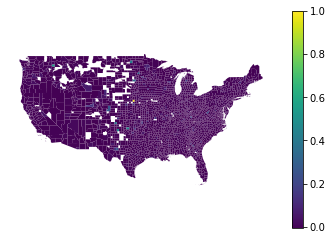

In [263]:
fig, ax, geodf = map_viz.word_prop('horizontal', global_words, valid_cnt, word_vectors, us_counties)

In [187]:
iloc_word = np.where(global_words['word'].values == 'nigga')[0][0]
y = word_vectors[:, iloc_word]
l_mi = esda.moran.Moran_Local(y, contiguity)

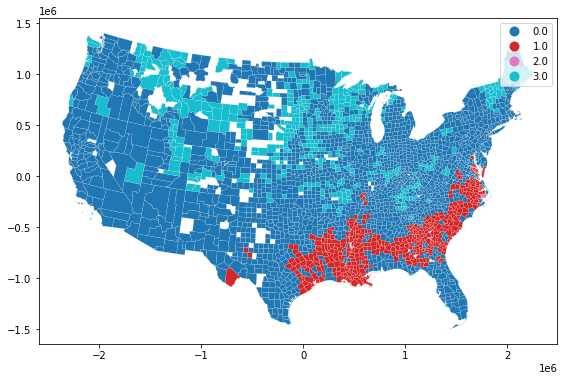

In [188]:
fig, ax = plt.subplots(1, figsize=(10,6))
assoc = np.zeros(geodf.shape[0])
sig = l_mi.p_sim < 0.05
assoc[sig] = l_mi.q[sig]
(geodf.assign(assoc=assoc)
      .plot(column='assoc', categorical=True, linewidth=0.1, ax=ax,
            edgecolor='white', legend=True))

### PCA

In [456]:
n_components = 20

In [457]:
pca = PCA(n_components=n_components)
pca.fit(reg_word_vectors)

PCA(n_components=20)

In [458]:
proj_vectors = pca.transform(reg_word_vectors)

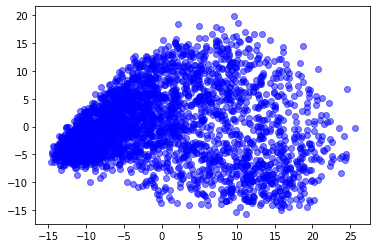

In [474]:
plt.scatter(proj_vectors[:, 0], proj_vectors[:, 1], c='b', alpha=0.5)

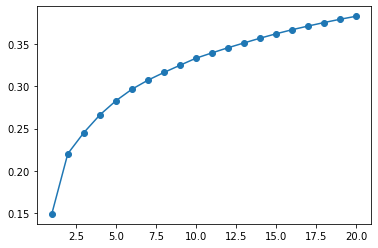

In [459]:
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')

In [425]:
a = reg_counts.loc[is_regional].copy()
i_comp = 0
a[f'comp{i_comp}_load'] = pca.components_[i_comp]
a.sort_values(by=f'comp{i_comp}_load', key=np.abs, ascending=False).head(20)

count  count_upper  nr_cells  is_proper  nr_cell_mask         I  \
word                                                                           
got       29577293            0      3073      False          True  0.710117   
nigga      8735272            0      2995      False          True  0.681629   
niggas     4543422            0      2894      False          True  0.653975   
these      9012541            0      3069      False          True  0.678085   
shit      18696134            0      3066      False          True  0.560430   
somebody   2356834            0      3012      False          True  0.713027   
ai         7420813            0      3052      False          True  0.730051   
nobody     2540465            0      3017      False          True  0.685027   
does       8763212            0      3066      False          True  0.468638   
bout       3804187            0      3034      False          True  0.721021   
real       7542741            0      3064      False          True  0.492386   
they      23019535            0      3073      False          True  0.477232   
damn       7271808            0      3065      False          True  0.540745   
yo         4528730            0      3011      False          True  0.613064   
thots       241300            0      2308      False          True  0.478676   
hoes       1907704            0      2903      False          True  0.685533   
wan       12168538            0      3067      False          True  0.475088   
yall       6916534            0      3024      False          True  0.832727   
ass       10817978            0      3064      False          True  0.617784   
em         2223185            0      3022      False          True  0.536180   

            z_value  p_value  comp0_load  
word                                      
got       64.385144    0.001    0.127186  
nigga     58.834592    0.001    0.102924  
niggas    59.267223    0.001    0.101595  
these     61.830843    0.001    0.101211  
shit      50.772262    0.001    0.100146  
somebody  61.613840    0.001    0.094977  
ai        63.242124    0.001    0.089388  
nobody    60.036089    0.001    0.088698  
does      40.786484    0.001   -0.088467  
bout      61.915036    0.001    0.087564  
real      42.819900    0.001    0.086266  
they      41.987510    0.001    0.085457  
damn      49.339125    0.001    0.085445  
yo        57.694646    0.001    0.085420  
thots     42.880308    0.001    0.083890  
hoes      60.860402    0.001    0.083640  
wan       41.627256    0.001    0.083093  
yall      72.600896    0.001    0.082932  
ass       55.583071    0.001    0.082819  
em        47.801731    0.001    0.081519

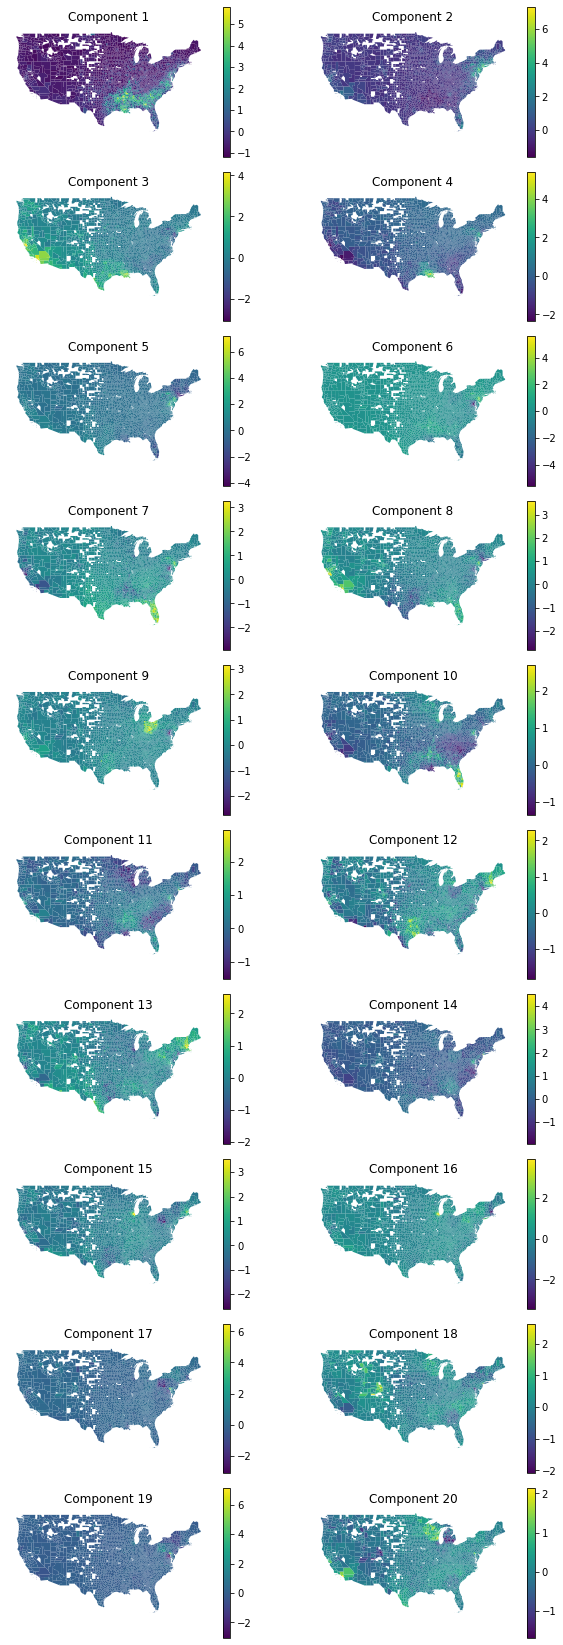

In [143]:
nr_cols = min(2, n_components)
nr_rows = n_components // nr_cols + n_components % nr_cols
fig, axes = plt.subplots(ncols=nr_cols, nrows=nr_rows,
                         figsize=(10, 3*nr_rows))
for i, ax in enumerate(axes.flat[:n_components]):
    proj_cnt = pd.Series(proj_vectors[:,i], index=valid_cnt, name='pca_comp')
    fig, ax, _ = map_viz.basic(us_counties, proj_cnt, fig=fig, ax=ax)
    ax.set_title(f'Component {i+1}')
fig.subplots_adjust(hspace=0.1)
fig.show()

TF IDF components

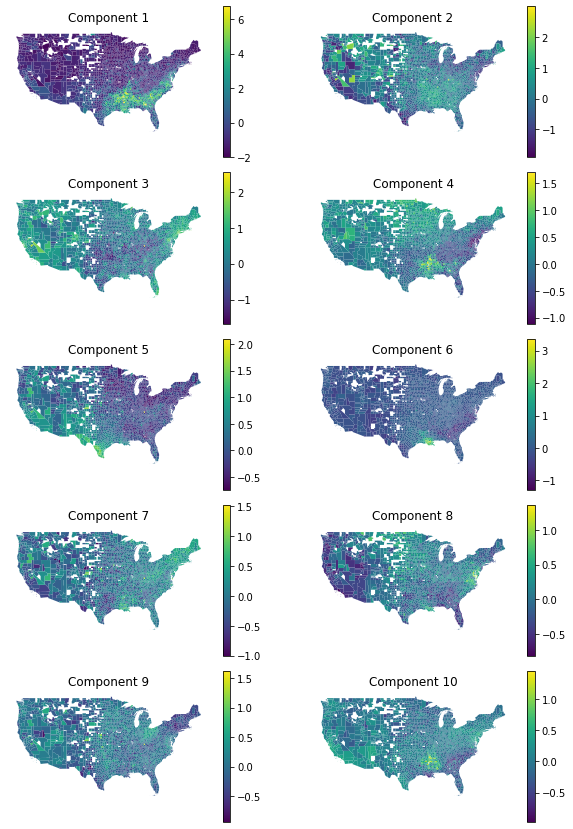

In [693]:
nr_cols = min(2, n_components)
nr_rows = n_components // nr_cols + int(n_components % nr_cols > 0)

fig, axes = plt.subplots(ncols=nr_cols, nrows=nr_rows,
                         figsize=(10, 3*nr_rows))
for i, ax in enumerate(axes.flat[:n_components]):
    proj_cnt = pd.Series(proj_vectors[:,i], index=valid_cnt, name='pca_comp')
    fig, ax, _ = map_viz.basic(us_counties, proj_cnt, fig=fig, ax=ax)
    ax.set_title(f'Component {i+1}')
fig.subplots_adjust(hspace=0.1)
fig.show()

In [605]:
proj_vectors.shape

(2925, 10)

### Clustering

#### Hierarc eucl

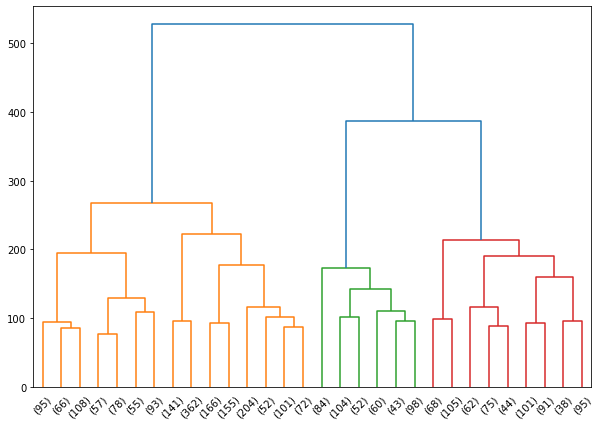

In [477]:
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
max_nr_clusters = 4
linkage = shc.linkage(proj_vectors, **agg_clustering_params)
nr_clusters_arr = np.asarray(range(2, max_nr_clusters + 1))
cutree = shc.cut_tree(linkage, n_clusters=nr_clusters_arr)
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

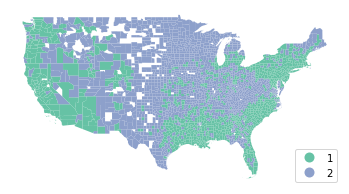

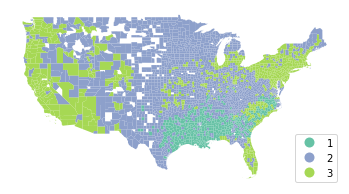

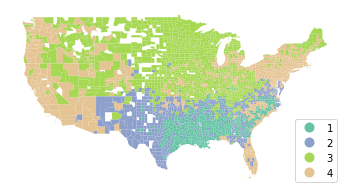

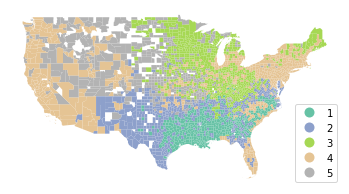

In [466]:
plot_kw = {'legend_kwds': {'loc': 'lower right'}, 'cmap': 'Set2', 'vmax': max_nr_clusters-1}
for i, n_clusters in enumerate(nr_clusters_arr):
    cnt_clusters = cutree[:, i]
    fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, **plot_kw)

For n_clusters = 2 The average silhouette_score is : 0.9511739381036347
For n_clusters = 3 The average silhouette_score is : 0.8550799298019403
For n_clusters = 4 The average silhouette_score is : 0.32033549435668324
For n_clusters = 5 The average silhouette_score is : 0.32305211789488075


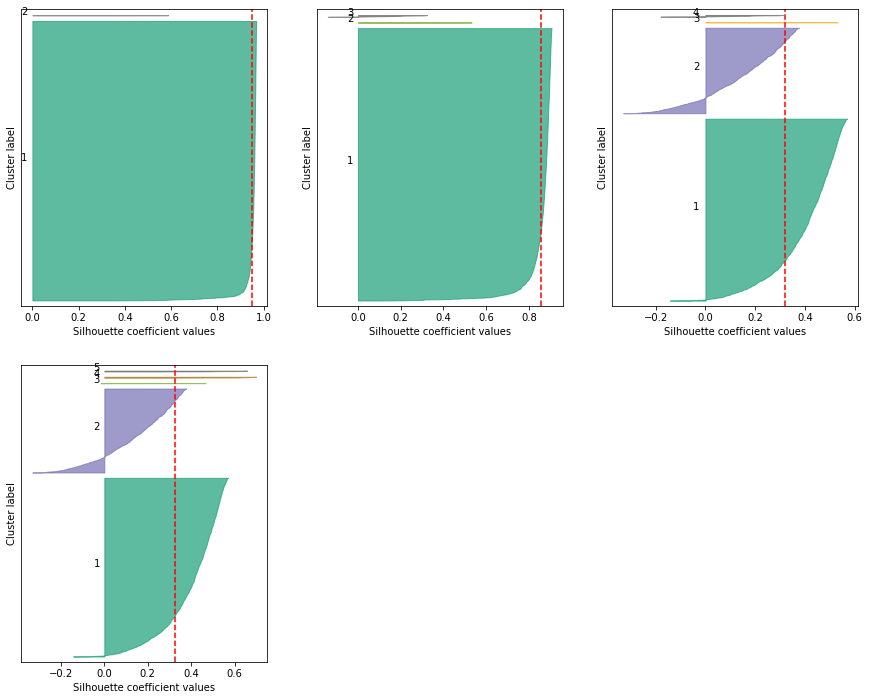

In [645]:
n_plots = len(nr_clusters_arr)
nr_cols = min(3, n_plots)
nr_rows = n_plots // nr_cols + int(n_plots % nr_cols > 0)
fig, axes = plt.subplots(ncols=nr_cols, nrows=nr_rows,
                         figsize=(15, 6*nr_rows))

for i, (n_clusters, ax) in enumerate(zip(nr_clusters_arr, axes.flat[:n_plots])):
    cluster_labels = cutree[:, i]
    fig, ax = eval_viz.silhouette(proj_vectors, cluster_labels,
                                  metric=agg_clustering_params['metric'], fig=fig, ax=ax)
for ax in axes.flat[n_plots:]:
    ax.set_axis_off()
    
fig.subplots_adjust(hspace=0.2)
params_str = '_'.join(["{}={}".format(key, value) for key, value in agg_clustering_params.items()])
sil_save_path = figs_path / word_vec_var / 'clusters' / f'sil_ncomp={n_components}_{params_str}.pdf'
sil_save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(sil_save_path, bbox_inches='tight')
fig.show()

#### Hierarc cos

tf idf

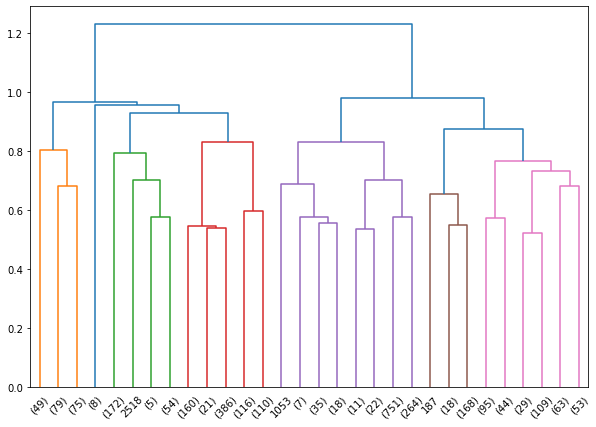

In [467]:
agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
linkage = shc.linkage(proj_vectors, **agg_clustering_params)
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

In [159]:
max_nr_clusters = 8
nr_clusters_arr = np.asarray(range(2, max_nr_clusters + 1))
cutree = shc.cut_tree(linkage, n_clusters=nr_clusters_arr)

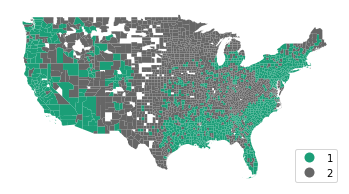

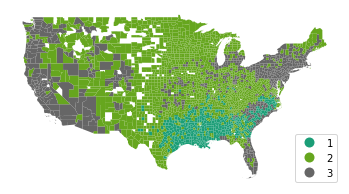

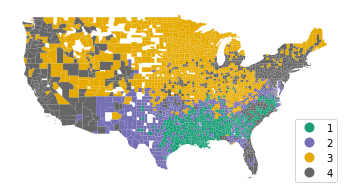

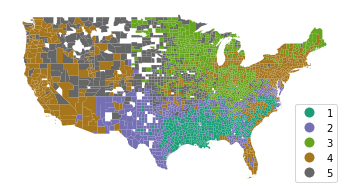

In [468]:
plot_kw = {'legend_kwds': {'loc': 'lower right'}, 'cmap': 'Dark2'}
for i, n_clusters in enumerate(nr_clusters_arr):
    cnt_clusters = cutree[:, i]
    fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, **plot_kw)

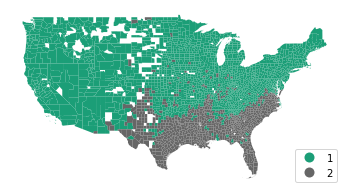

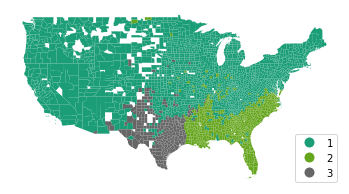

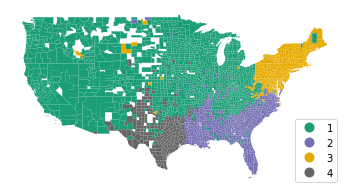

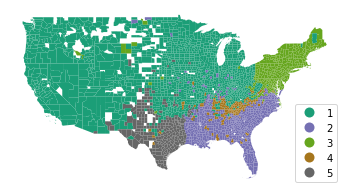

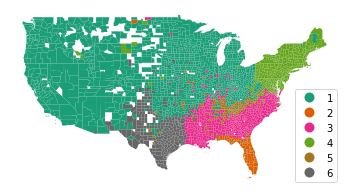

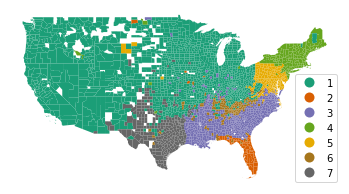

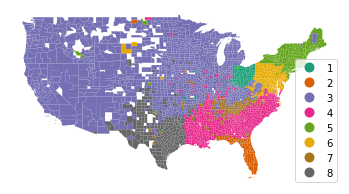

In [149]:
plot_kw = {'legend_kwds': {'loc': 'lower right'}, 'cmap': 'Dark2'}
for i, n_clusters in enumerate(nr_clusters_arr):
    cnt_clusters = cutree[:, i]
    fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, **plot_kw)

In [213]:
n_clust_plot = max_nr_clusters
params_str = '_'.join(["{}={}".format(key, value) for key, value in agg_clustering_params.items()])
cluster_labels = cutree[:, nr_clusters_arr == n_clust_plot].flatten()
html_save_path = figs_path / word_vec_var / 'clusters' / f'clusters_ncomp={n_components}_{params_str}_nclusters={n_clust_plot}.html'
html_save_path.parent.mkdir(parents=True, exist_ok=True)
fig = interact_viz.clusters(us_counties[['geometry']], cluster_labels, valid_cnt, mapbox_zoom=3, save_path=html_save_path, show=True)

/home/thomaslouf/Documents/code/words-use/src/visualization/interactive.py:97: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




http://localhost:8989/files/reports/figures/raw_tf-idf/clusters/clusters_ncomp=20_metric=cosine_method=average_nclusters=8.html


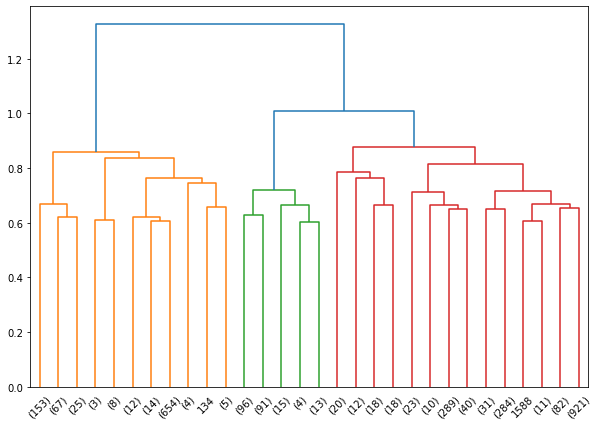

In [426]:
agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
linkage = shc.linkage(proj_vectors, **agg_clustering_params)
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

ideally should put two first clusters at 1/4 and 3/4 of cmap, then when they divide, occupy, if it's the first one, 1/8 and 3/8, etc

In [427]:
max_nr_clusters = 4
nr_clusters_arr = np.asarray(range(2, max_nr_clusters + 1))
cutree = shc.cut_tree(linkage, n_clusters=nr_clusters_arr)

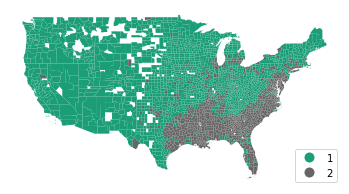

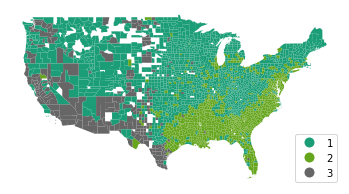

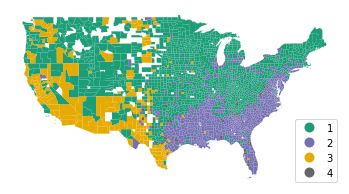

In [719]:
plot_kw = {'legend_kwds': {'loc': 'lower right'}, 'cmap': 'Dark2'}
for i, n_clusters in enumerate(nr_clusters_arr):
    cnt_clusters = cutree[:, i]
    fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, **plot_kw)

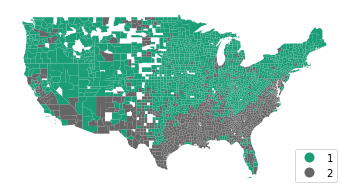

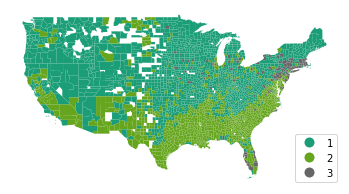

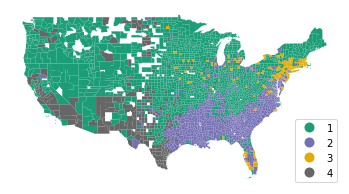

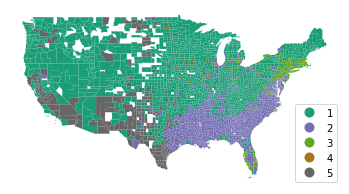

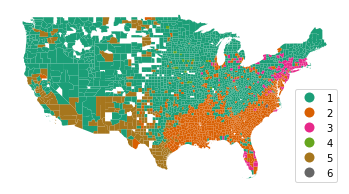

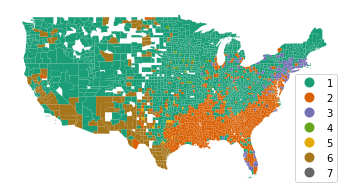

In [346]:
plot_kw = {'legend_kwds': {'loc': 'lower right'}, 'cmap': 'Dark2'}
for i, n_clusters in enumerate(nr_clusters_arr):
    cnt_clusters = cutree[:, i]
    fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, **plot_kw)

In [720]:
n_clust_plot = max_nr_clusters
params_str = '_'.join(["{}={}".format(key, value) for key, value in agg_clustering_params.items()])
cluster_labels = cutree[:, nr_clusters_arr == n_clust_plot].flatten()
html_save_path = figs_path / word_vec_var / 'clusters' / f'clusters_ncomp={n_components}_{params_str}_nclusters={n_clust_plot}.html'
html_save_path.parent.mkdir(parents=True, exist_ok=True)
fig = interact_viz.clusters(us_counties[['geometry']], cluster_labels, valid_cnt, mapbox_zoom=3, save_path=html_save_path, show=True)

/home/thomaslouf/Documents/code/words-use/src/visualization/interactive.py:89: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




For n_clusters = 2 The average silhouette_score is : 0.4563457859940861
For n_clusters = 3 The average silhouette_score is : 0.3523910307264365
For n_clusters = 4 The average silhouette_score is : 0.28915882693157585


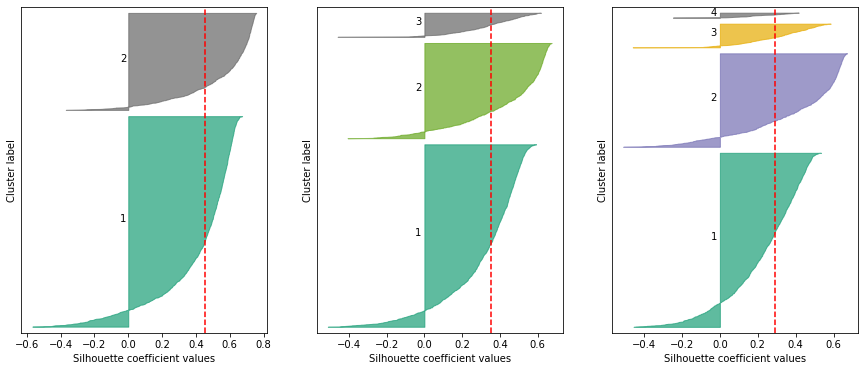

In [721]:
n_plots = len(nr_clusters_arr)
nr_cols = min(3, n_plots)
nr_rows = n_plots // nr_cols + int(n_plots % nr_cols > 0)
fig, axes = plt.subplots(ncols=nr_cols, nrows=nr_rows,
                         figsize=(15, 6*nr_rows))

for i, (n_clusters, ax) in enumerate(zip(nr_clusters_arr, axes.flat[:n_plots])):
    cluster_labels = cutree[:, i]
    fig, ax = eval_viz.silhouette(proj_vectors, cluster_labels,
                                  metric=agg_clustering_params['metric'], fig=fig, ax=ax)
for ax in axes.flat[n_plots:]:
    ax.set_axis_off()
    
fig.subplots_adjust(hspace=0.2)
params_str = '_'.join(["{}={}".format(key, value) for key, value in agg_clustering_params.items()])
sil_save_path = figs_path / word_vec_var / 'clusters' / f'sil_ncomp={n_components}_{params_str}.pdf'
sil_save_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(sil_save_path, bbox_inches='tight')
fig.show()

#### DBSCAN / OPTICS

In [351]:
dbscan_params = {'eps': .06, 'min_samples': 40, 'metric': 'cosine'}
db = sklearn.cluster.DBSCAN(**dbscan_params).fit(proj_vectors)
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(n_clusters, n_noise)

1 2614


For n_clusters = 2 The average silhouette_score is : -0.12070910528931648


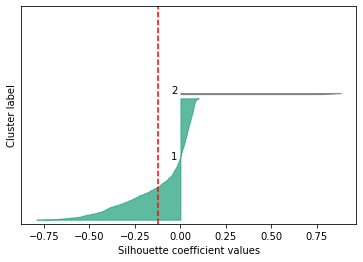

In [739]:
fig, ax = eval_viz.silhouette(proj_vectors, db.labels_, metric=dbscan_params['metric'])

In [213]:
opt_params = {'min_samples': 40, 'xi': 0.002, 'min_cluster_size': 5, 'metric': 'cosine'}
optics = sklearn.cluster.OPTICS(**opt_params)
# Run the fit
optics.fit(proj_vectors)
space = np.arange(len(proj_vectors))
reachability = optics.reachability_[optics.ordering_]
ordered_labels = optics.labels_[optics.ordering_]
print(np.unique(ordered_labels).max()-1, np.sum(ordered_labels == -1))

7 1808


Text(0.5, 1.0, 'Reachability Plot')

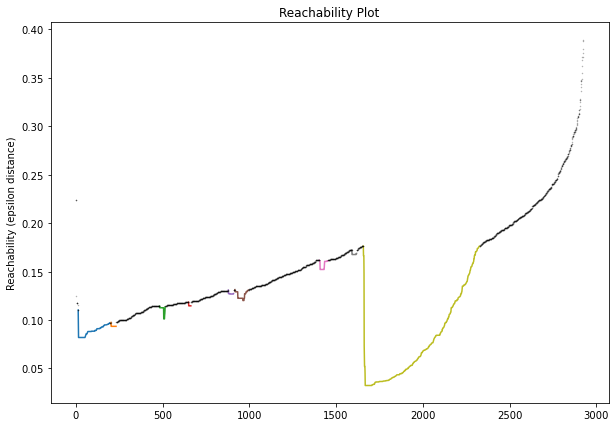

In [360]:
fig, ax = plt.subplots(1, figsize=(10, 7))

# Reachability plot
for klass in np.unique(ordered_labels)[1:]:
    Xk = space[ordered_labels == klass]
    Rk = reachability[ordered_labels == klass]
    ax.plot(Xk, Rk)
ax.plot(space[ordered_labels == -1], reachability[ordered_labels == -1], 'k.', alpha=0.3, ms=1)
ax.set_ylabel('Reachability (epsilon distance)')
ax.set_title('Reachability Plot')

In [365]:
lab = sklearn.cluster.cluster_optics_dbscan(reachability=optics.reachability_,
                                            core_distances=optics.core_distances_,
                                            ordering=optics.ordering_, eps=0.09)
print(len(np.unique(lab[lab >= 0])), (lab >= 0).sum())

2 557


For n_clusters = 9 The average silhouette_score is : -0.14709898667640967 and considering noise as singletons clusters:  0.48441296684466706


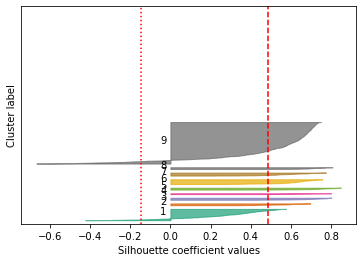

In [232]:
fig, ax = eval_viz.silhouette(proj_vectors, optics.labels_, metric=opt_params['metric'])

In [314]:
params_str = '_'.join(["{}={}".format(key, value) for key, value in opt_params.items()])
cluster_labels = optics.labels_
html_save_path = figs_path / word_vec_var / 'clusters' / f'optics_clusters_ncomp={n_components}_{params_str}.html'
html_save_path.parent.mkdir(parents=True, exist_ok=True)
fig = interact_viz.clusters(us_counties[['geometry']], cluster_labels, valid_cnt, mapbox_zoom=3,
                            save_path=html_save_path, show=True)

/home/thomaslouf/Documents/code/words-use/src/visualization/interactive.py:94: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




http://localhost:8989/files/reports/figures/normed_freqs/clusters/optics_clusters_ncomp=20_min_samples=40_xi=0.002_min_cluster_size=5_metric=cosine.html


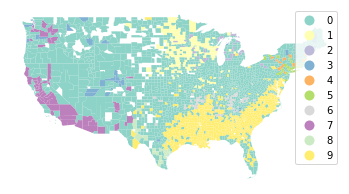

In [1025]:
fig, ax, _ = map_viz.clusters(us_counties, optics.labels_, valid_cnt, cmap='Set3')

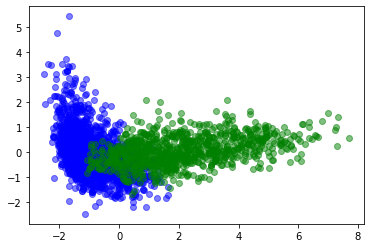

In [552]:
hierarc_clust = cutree[:, 0]
plt.scatter(proj_vectors[hierarc_clust==0, 0], proj_vectors[hierarc_clust==0, 1], c='b', alpha=0.5)
plt.scatter(proj_vectors[hierarc_clust==1, 0], proj_vectors[hierarc_clust==1, 1], c='g', alpha=0.5)

#### GMM

In [13]:
import sklearn.mixture

In [40]:
dpgmm = sklearn.mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full').fit(proj_vectors)
dpgmm_res = dpgmm.predict(proj_vectors)

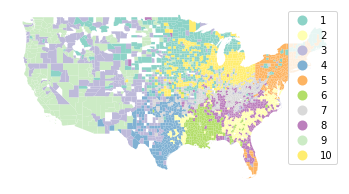

In [41]:
fig, ax, _ = map_viz.clusters(us_counties, dpgmm_res, valid_cnt, cmap='Set3')

In [290]:
gmm = sklearn.mixture.GaussianMixture(n_components=6,
                                      covariance_type='full').fit(proj_vectors)
gmm_labels = gmm.predict(proj_vectors)

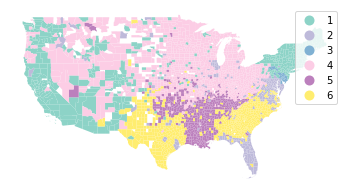

In [291]:
fig, ax, _ = map_viz.clusters(us_counties, gmm_labels, valid_cnt, cmap='Set3')

In [221]:
import sklearn.metrics

In [230]:
print(sklearn.metrics.adjusted_mutual_info_score(cutree[:, -1], gmm_labels),
      sklearn.metrics.adjusted_rand_score(cutree[:, -1], gmm_labels),
     sklearn.metrics.rand_score(cutree[:, -1], gmm_labels))

0.37948397291623936 0.4420991114997051 0.7075049984215511


In [72]:
from scipy.stats import multivariate_normal

In [88]:
gmm_distribs = [multivariate_normal(mu, cov) for mu, cov in zip(gmm.means_, gmm.covariances_)]
# Norm by max of pdf?
gmm_data_p_density = np.asarray([[d.pdf(x) for d in gmm_distribs] for x in proj_vectors])

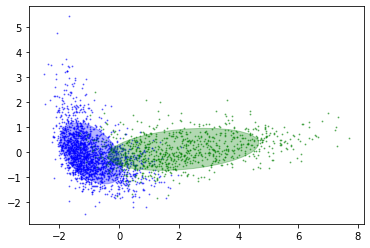

In [114]:
import matplotlib.patches
from scipy import linalg
color_iter = ['b', 'g']
fig, ax = plt.subplots(1)
for i, (mean, covar, color) in enumerate(zip(
        gmm.means_, gmm.covariances_, color_iter)):
    v, w = linalg.eigh(covar[:2, :2])
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(gmm_labels == i):
        continue
    ax.scatter(proj_vectors[gmm_labels == i, 0], proj_vectors[gmm_labels == i, 1], .8, color=color, alpha=0.5)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = matplotlib.patches.Ellipse(mean[:2], v[0], v[1], angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    ax.add_artist(ell)
fig.show()

### Community detection on graphs

In [23]:
import scipy.spatial.distance

In [24]:
metric = 'cosine'
dist_mat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(proj_vectors, metric=metric))

In [810]:
im = Infomap()
for i in range(nr_counties):
    for j in range(i+1, nr_counties):
        im.add_link(i, j, weight=1 / dist_mat[i, j])

In [811]:
im.run()
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

# print("Result")
# print("\n#node module")
# for node in im.tree:
#     if node.is_leaf:
#         print(node.node_id, node.module_id)

Found 1 modules with codelength: 11.478992302129825


TODO: 

`2*arctanh(1-correlation)` (and `2*arctanh(1-cosine))`) into SBM with rec_types=["real-normal"]

log(euclidean) into SBM with rec_types=["real-normal"]

In [303]:
edge_list = []
for i in range(nr_counties):
    for j in range(i+1, nr_counties):
#         edge_list.append((i, j, 1 / dist_mat[i, j]))
        edge_list.append((i, j, 2*np.arctanh(1-dist_mat[i, j])))

G = nx.Graph()
G.add_weighted_edges_from(edge_list)

Louvain

In [1072]:
louvain_hierarc = community.generate_dendrogram(G)

In [1074]:
len(louvain_hierarc)

1

In [814]:
louvain_partition = community.best_partition(G)

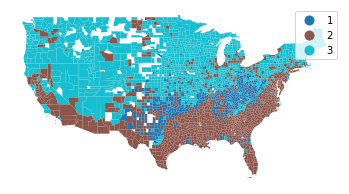

In [826]:
fig, ax, _ = map_viz.clusters(us_counties, np.asarray([x for x in louvain_partition.values()]), valid_cnt)

Oslom

In [25]:
oslom_net_file = f'oslom_net_metric={metric}_transfo=2arctanh.dat'
oslom_net_file_path = processed_data_path / oslom_net_file
nx.write_weighted_edgelist(G, oslom_net_file_path)

In [319]:
@ray.remote
def remote_run_oslom(*run_oslom_args, **run_oslom_kwargs):
    return data_clustering.run_oslom(*run_oslom_args, **run_oslom_kwargs)

In [26]:
ray.init(num_cpus=2)

2021-02-23 10:54:22,085	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.34.1.5',
 'raylet_ip_address': '10.34.1.5',
 'redis_address': '10.34.1.5:57349',
 'object_store_address': '/tmp/ray/session_2021-02-23_10-54-17_694368_18725/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-23_10-54-17_694368_18725/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-23_10-54-17_694368_18725',
 'metrics_export_port': 64246,
 'node_id': '1a3e0c630c6a40363ec2bc5eaba5ca922cf56fbd505f99aa41202146'}

In [8]:
oslom_opt_params = ['-singlet', '-r', '50']
oslom_res_path = data_clustering.gen_oslom_res_path(oslom_net_file_path, oslom_opt_params)
obj_ref = remote_run_oslom.remote(OSLOM_DIR, oslom_net_file_path, oslom_res_path, oslom_opt_params=oslom_opt_params, silent=True)
# p = data_clustering.run_oslom(OSLOM_DIR, oslom_net_file_path, oslom_res_path, oslom_opt_params=oslom_opt_params)
# p, oslom_res_path = data_clustering.run_oslom(OSLOM_DIR, oslom_net_file_path, oslom_opt_params=oslom_opt_params)
# _, oslom_res_path = data_clustering.gen_oslom_res_path(oslom_net_file_path, oslom_opt_params)

In [231]:
cluster_dict = data_clustering.read_oslom_res(oslom_res_path)

- level 2
cluster 0, size: 2, p-value:  8.68359e-101
cluster 1, size: 2894, p-value:  5.40156e-101
cluster 2, size: 46, p-value:  1
- level 1
cluster 0, size: 49, p-value:  0.078225
cluster 1, size: 1988, p-value:  0.0187403
cluster 2, size: 85, p-value:  1
cluster 3, size: 125, p-value:  1
cluster 4, size: 92, p-value:  1
cluster 5, size: 103, p-value:  1
cluster 6, size: 118, p-value:  1
cluster 7, size: 132, p-value:  1
cluster 8, size: 46, p-value:  1
cluster 9, size: 173, p-value:  1
cluster 10, size: 85, p-value:  1
cluster 11, size: 145, p-value:  1
cluster 12, size: 186, p-value:  1
- level 0
cluster 0, size: 270, p-value:  0.0164355
cluster 1, size: 138, p-value:  0.0162988
cluster 2, size: 85, p-value:  0.026663
cluster 3, size: 125, p-value:  5.11458e-06
cluster 4, size: 92, p-value:  0.000864686
cluster 5, size: 103, p-value:  0.00554562
cluster 6, size: 118, p-value:  4.18609e-08
cluster 7, size: 132, p-value:  0.0496036
cluster 8, size: 46, p-value:  0.0765527
cluster 9, 

In [ ]:
ray.shutdown()

cosine distance: at higher hierarchical level, only two clusters, one with very few random counties and the other with the rest

In [23]:
lvl = 1
params_str = ''.join(oslom_opt_params)
html_save_path = figs_path / word_vec_var / 'clusters' / f'oslom_clusters_ncomp={n_components}_metric={metric}{params_str}_lvl={lvl}.html'
html_save_path.parent.mkdir(parents=True, exist_ok=True)
fig = interact_viz.clusters(us_counties[['geometry']], cluster_dict[lvl], valid_cnt, mapbox_zoom=3,
                            save_path=html_save_path, show=True)

/home/thomaslouf/Documents/code/words-use/src/visualization/interactive.py:95: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




http://localhost:8989/files/reports/figures/normed_freqs/clusters/oslom_clusters_ncomp=20_metric=cosine-singlet-r50_lvl=1.html


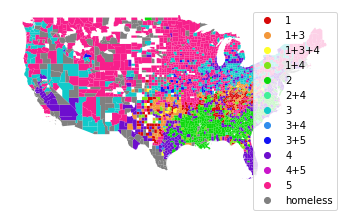

In [125]:
fig, ax, _ = map_viz.overlap_clusters(us_counties.loc[valid_cnt, ['geometry']], cluster_dict[0])

In [22]:
oslom_clusters[0].keys()

dict_keys([0, 4, 11, 30, 34, 51, 53, 57, 75, 76, 77, 79, 84, 91, 92, 96, 107, 124, 146, 147, 148, 149, 150, 151, 153, 154, 158, 166, 171, 172, 193, 194, 197, 201, 221, 229, 256, 265, 269, 272, 274, 280, 282, 284, 305, 315, 318, 341, 347, 349, 367, 369, 371, 375, 402, 417, 430, 432, 444, 448, 449, 450, 452, 453, 473, 488, 490, 491, 507, 514, 518, 527, 530, 538, 540, 542, 543, 544, 553, 554, 563, 568, 595, 597, 604, 609, 613, 615, 616, 619, 626, 636, 640, 657, 671, 672, 675, 676, 686, 687, 699, 702, 710, 713, 724, 730, 731, 732, 752, 755, 756, 769, 781, 783, 791, 794, 796, 797, 805, 814, 815, 816, 823, 831, 837, 840, 855, 856, 857, 858, 865, 867, 877, 878, 890, 893, 895, 913, 914, 919, 920, 923, 935, 944, 945, 947, 948, 949, 956, 958, 964, 965, 980, 986, 996, 997, 1002, 1004, 1015, 1020, 1023, 1029, 1035, 1039, 1041, 1053, 1058, 1065, 1068, 1078, 1084, 1090, 1100, 1115, 1142, 1153, 1161, 1176, 1178, 1181, 1183, 1192, 1197, 1210, 1212, 1215, 1216, 1225, 1232, 1238, 1239, 1241, 1242, 1245,

without -singlet

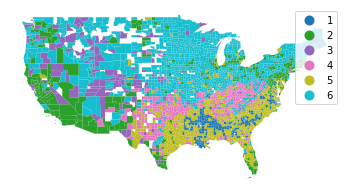

In [896]:
cnt_clusters = np.asarray([oslom_clusters[0][x] for x in sorted(oslom_clusters[0].keys())])
fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, cmap='Dark2')

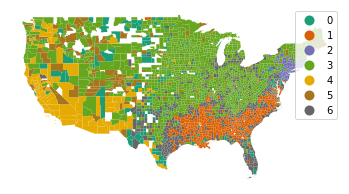

In [907]:
# 0 is noise here
cnt_clusters = np.asarray([oslom_clusters[0][x] for x in sorted(oslom_clusters[0].keys())])
fig, ax, _ = map_viz.clusters(us_counties, cnt_clusters, valid_cnt, cmap='Dark2')

SBM

In [27]:
import graph_tool.all as gt

In [28]:
G = gt.graph_tool.load_graph_from_csv(
    str(oslom_net_file_path), strip_whitespace=False, csv_options={'delimiter': ' '},
    eprop_names=['weight'], eprop_types=['float'], )

In [70]:
ray.init(num_cpus=4)

2021-02-24 14:21:42,224	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.34.1.5',
 'raylet_ip_address': '10.34.1.5',
 'redis_address': '10.34.1.5:48910',
 'object_store_address': '/tmp/ray/session_2021-02-24_14-21-32_727316_18725/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-24_14-21-32_727316_18725/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-02-24_14-21-32_727316_18725',
 'metrics_export_port': 51236,
 'node_id': '8360228a460076ead46b2b90ad879b6ad6ee3dc2766cac9cf654e6fb'}

In [71]:
@ray.remote
def remote_sbm(file_path, *args, **kwargs):
    state = gt.minimize_nested_blockmodel_dl(*args, **kwargs)
    return state

In [72]:
arctan_cosine_ref = remote_sbm.remote(
    f'state_{oslom_net_file}.pkl', G, 
    state_args=dict(recs=[G.ep.weight], rec_types=["real-normal"]))

(pid=61550) 
(pid=61550) (default_worker.py:61550): Gtk-WARNING **: 14:22:09.007: Locale not supported by C library.
(pid=61550) 	Using the fallback 'C' locale.
(pid=61550) 
(pid=61550) (default_worker.py:61550): Gtk-WARNING **: 14:22:09.007: Locale not supported by C library.
(pid=61550) 	Using the fallback 'C' locale.
(pid=61550) 
(pid=61550) (default_worker.py:61550): Gtk-WARNING **: 14:22:09.007: Locale not supported by C library.
(pid=61550) 	Using the fallback 'C' locale.
(pid=61550) 
(pid=61550) (default_worker.py:61550): Gtk-WARNING **: 14:22:09.007: Locale not supported by C library.
(pid=61550) 	Using the fallback 'C' locale.
(pid=61552) 
(pid=61552) (default_worker.py:61552): Gtk-WARNING **: 14:22:09.001: Locale not supported by C library.
(pid=61552) 	Using the fallback 'C' locale.
(pid=61552) 
(pid=61552) (default_worker.py:61552): Gtk-WARNING **: 14:22:09.001: Locale not supported by C library.
(pid=61552) 	Using the fallback 'C' locale.
(pid=61552) 
(pid=61552) (default_

In [ ]:
state = gt.minimize_nested_blockmodel_dl(G, state_args=dict(recs=[G.ep.weight],
                                                            rec_types=["real-normal"]))

In [32]:
L1 = -state.entropy()
print(L1)

-4044534.245372805


In [63]:
impr_state = state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling=True)

NameError: name 'state' is not defined

In [152]:
# improve solution with merge-split
impr_state = state.copy(bs=state.get_bs() + [np.zeros(1)] * 4, sampling=True)

for i in tqdm(range(10)):
    ret = impr_state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

100%|██████████| 10/10 [04:43<00:00, 28.40s/it]


In [35]:
L2 = state.entropy()
print(L2 - L1)

8089068.49074561


In [176]:
levels = impr_state.get_levels()
lvl = 0
cnt_clusters = np.asarray([c for c in levels[0].get_blocks()])
cluster_dict[0] = cnt_clusters.copy()
for l in range(1, len(levels)):
    cnt_clusters = np.asarray([list(levels[l].get_blocks())[c] for c in cnt_clusters])
    cluster_dict[l] = cnt_clusters.copy()

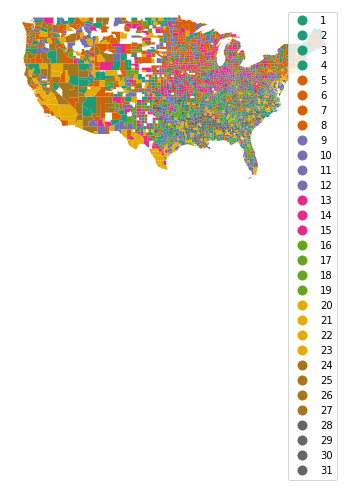

In [155]:
fig, ax, _ = map_viz.clusters(us_counties, list(cluster_dict[0], valid_cnt, cmap='Dark2')

In [202]:
lvl = 2
params_str = ''.join(oslom_opt_params)
html_save_path = figs_path / word_vec_var / 'clusters' / f'sbm_clusters_ncomp={n_components}_metric={metric}{params_str}_lvl={lvl}.html'
html_save_path.parent.mkdir(parents=True, exist_ok=True)
fig = interact_viz.clusters(us_counties[['geometry']], cluster_dict[lvl], valid_cnt, mapbox_zoom=3,
                            save_path=html_save_path, show=True)

/home/thomaslouf/Documents/code/words-use/src/visualization/interactive.py:89: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### FA

In [284]:
from sklearn.decomposition import FactorAnalysis

In [285]:
n_components = 10
fa = FactorAnalysis(n_components=n_components)
fa.fit(reg_word_vectors)

FactorAnalysis(n_components=10)

In [286]:
m = np.sum(fa.components_**2, axis=1)
for i in range(n_components):
    print((100*m[i]) / (np.sum(m))) # + np.sum(fa.noise_variance_)))

50.53807873920879
21.144463683160655
11.163986461715654
13.578970247443841
0.2884111394826459
0.9082539099595281
0.7772407195447107
0.40044654045489725
0.5783555613169983
0.6217929977122718


In [316]:
total_var = np.var(reg_word_vectors, ddof=1, axis=0)
for n_comp in range(1,n_components+1):
    Ih = np.eye(n_comp)

    X_transformed = reg_word_vectors - fa.mean_

    Wpsi = fa.components_[:n_comp, :] / fa.noise_variance_
    cov_z = np.linalg.inv(Ih + np.dot(Wpsi, fa.components_[:n_comp, :].T))
    tmp = np.dot(X_transformed, Wpsi.T)
    X_transformed = np.dot(tmp, cov_z)
    print(np.var(X_transformed, ddof=1, axis=0) / total_var.sum())

[4367.30505022]
[4367.30505022 4358.97805455]
[4367.30505022 4358.97805455 4302.15741803]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188 4208.42140814]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188 4208.42140815
 4192.79117546]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188 4208.42140815
 4192.79117545 4164.75332339]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188 4208.42140815
 4192.79117546 4164.75332339 4127.34541389]
[4367.30505022 4358.97805455 4302.15741803 4287.27862188 4208.42140815
 4192.79117546 4164.75332342 4127.3454139  4092.71091962]
[4367.30505022 4358.97805455 4302.15741802 4287.27862188 4208.42140814
 4192.79117542 4164.7533234  4127.34541391 4092.71091957 4093.2338574 ]


In [287]:
proj_vectors = fa.transform(reg_word_vectors)

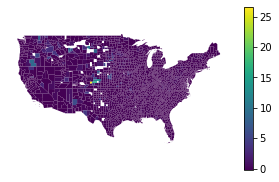

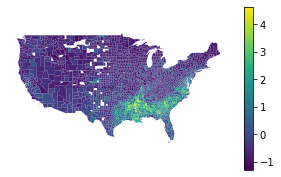

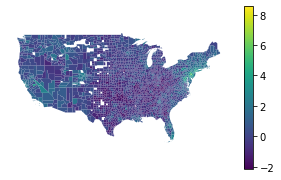

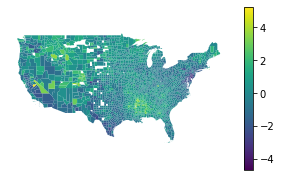

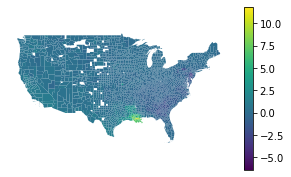

In [288]:
for i in range(n_components-5):
    fig, ax = plt.subplots(1, figsize=(5,3))
    proj_cnt = pd.Series(proj_vectors[:,i], index=valid_cnt, name='pca_comp')
    fig, ax, _ = map_viz.basic(us_counties, proj_cnt, fig=fig, ax=ax)

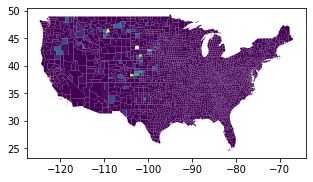

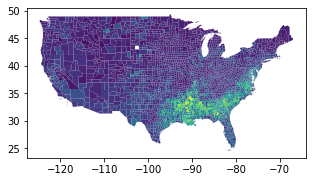

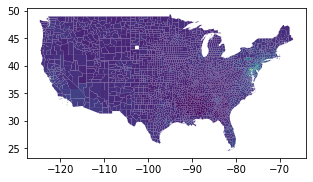

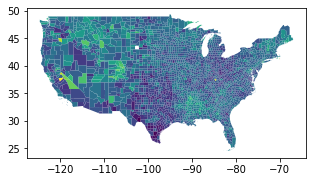

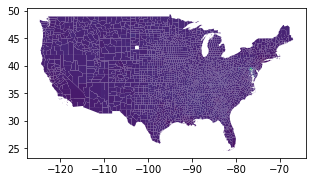

In [199]:
for i in range(n_components-5):
    fig, ax = plt.subplots(1, figsize=(5,3))
    proj_cnt = pd.Series(proj_vectors[:,i], index=valid_cnt, name='pca_comp')
    fig, ax, _ = map_viz.basic(us_counties, proj_cnt, fig=fig, ax=ax)

In [200]:
linkage = shc.linkage(proj_vectors, method='ward') #ward metric='cosine', 

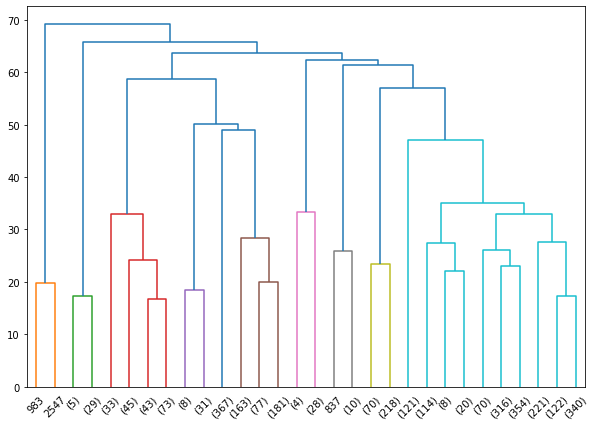

In [201]:
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

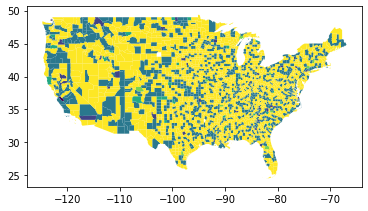

In [203]:
cnt_clusters = shc.fcluster(linkage, 6, criterion='maxclust')
hierarc_dict = {fips: cluster for fips, cluster in zip(fips_list, cnt_clusters)}
county_partition_df = us_counties[['geometry']].join(pd.Series(hierarc_dict, name='hierarc'), how='inner')
county_partition_df.plot(column='hierarc')

## Distribution shape

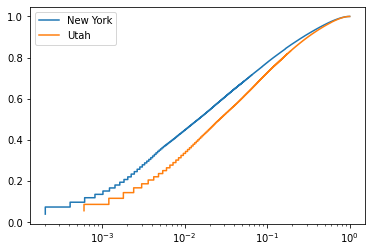

In [109]:
fig, ax = plt.subplots(1)
# ax.hist(x_plot, bins=len(y_plot), weights=y_plot, cumulative=True, label='Utah', histtype='step')
y_plot = counties_dict[36061]['grp_rank_counts'].cumsum()
max_x = len(y_plot) 
x_plot = (np.array(range(len(y_plot))) + 1) / max_x
ax.step(x_plot, y_plot, label='New York')


y_plot = counties_dict[49049]['grp_rank_counts'].cumsum()
max_x = len(y_plot)
# y_plot = counties_dict[49049]['grp_rank_counts']
x_plot = (np.array(range(len(y_plot))) + 1) / max_x
ax.step(x_plot, y_plot, label='Utah')
ax.set_xscale('log')
ax.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots(1)
y_plot = counties_dict[49049]['word_counts'].cumsum()
# y_plot = counties_dict[49049]['grp_rank_counts']
x_plot = np.array(range(len(y_plot))) + 1
ax.step(x_plot, y_plot, label='Utah')
# ax.hist(x_plot, bins=len(y_plot), weights=y_plot, cumulative=True, label='Utah', histtype='step')
y_plot = counties_dict[36061]['word_counts'].cumsum()
x_plot = np.array(range(len(y_plot))) + 1
ax.step(x_plot, y_plot, label='New York')
ax.set_xscale('log')
ax.legend()
fig.show()

In [ ]:
KS = np.max(np.abs([:min_size].cumsum() - grp_rank_counts2[:min_size].cumsum()))

### KS

In [107]:
def kl_div(obs, pred):
    '''
    Computes -obs*log(pred/obs), the elements over which one sums to get the
    Kullback Leibler divergence between the distribution defined by all the obs
    and the one defined by all the pred. pred == 0 must imply obs == 0.
    '''
    # We add these two steps to avoid a 0*log(0), as in Python 0**0 = 1, but
    # 0*log(0) is not a number.
    den = obs**obs
    num = pred**obs
    return -np.log10(num / den)

In [98]:
counties_dict[49049]['word_counts']['count']

KeyError: 'count'

In [ ]:
KS_mat = np.zeros((len(fips_list), len(fips_list)))
JS_mat = np.zeros((len(fips_list), len(fips_list)))

for i, fips1 in enumerate(fips_list):
    fips1_dict = counties_dict.get(fips1)
    ranks = np.arange(1, fips1_dict['word_counts'].shape[0]+1)
    counts = fips1_dict['word_counts'].values
    counts = counts / np.sum(counts)
    for j, fips2 in enumerate(fips_list[i+1:]):
        fips2_dict = counties_dict.get(fips2)
        ranks2 = np.arange(1, fips2_dict['word_counts'].shape[0]+1)
        counts2 = fips2_dict['word_counts'].values
        counts2 = counts2 / np.sum(counts2)
        
        min_size = min(len(counts), len(counts2))
        KS = np.max(np.abs(counts[:min_size].cumsum() - counts2[:min_size].cumsum()))
        KS_mat[i, j+i+1] = KS
        
        max_size = max(len(counts), len(counts2))
        matching_distrib = np.zeros(max_size)
        matching_distrib[:len(counts)] = counts
        matching_distrib2 = np.zeros(max_size)
        matching_distrib2[:len(counts2)] = counts2
        distrib_sum = (matching_distrib + matching_distrib2) / 2
        JS = np.sqrt((kl_div(matching_distrib, distrib_sum).sum()
                      + kl_div(matching_distrib2, distrib_sum).sum()) / 2)
        JS_mat[i, j+i+1] = JS
        
np.savetxt(processed_data_path / 'rank' / 'KS_mat.csv.gz', KS_mat)
np.savetxt(processed_data_path / 'rank' / 'JS_mat.csv.gz', JS_mat)

In [ ]:
KS_normed_mat = np.zeros((len(fips_list), len(fips_list)))
KS_mat = np.zeros((len(fips_list), len(fips_list)))
JS_mat = np.zeros((len(fips_list), len(fips_list)))

for i, fips1 in enumerate(fips_list):
    fips1_dict = counties_dict.get(fips1)
    normed_log_ranks = fips1_dict['normed_log_ranks']
    grp_rank_counts = fips1_dict['grp_rank_counts']
    for j, fips2 in enumerate(fips_list[i+1:]):
        fips2_dict = counties_dict.get(fips2)
        normed_log_ranks2 = fips2_dict['normed_log_ranks']
        grp_rank_counts2 = fips2_dict['grp_rank_counts']
        all_pts = np.unique(np.concatenate([normed_log_ranks, normed_log_ranks2]))
        N = len(all_pts)
        all_freqs1 = np.zeros(N)
        # We find indices where to insert the frequency values of fips1
        idx_values = np.searchsorted(all_pts, normed_log_ranks)
        # replace fips1_dict['word_counts']['count'].unique()  with fips1_dict['grp_rank_counts'] at next run
        all_freqs1[idx_values] = grp_rank_counts
        cdf1 = all_freqs1.cumsum()
        cdf1 /= cdf1[-1]
        all_freqs2 = np.zeros(N)
        idx_values = np.searchsorted(all_pts, normed_log_ranks2)
        all_freqs2[idx_values] = grp_rank_counts2
        cdf2 = all_freqs2.cumsum()
        cdf2 /= cdf2[-1]
        KS = np.max(np.abs(cdf1 - cdf2))
        KS_normed_mat[i, j+i+1] = KS
        
        min_size = min(len(grp_rank_counts), len(grp_rank_counts2))
        KS = np.max(np.abs(grp_rank_counts[:min_size].cumsum() - grp_rank_counts2[:min_size].cumsum()))
        KS_mat[i, j+i+1] = KS
        
        max_size = max(len(grp_rank_counts), len(grp_rank_counts2))
        matching_distrib = np.zeros(max_size)
        matching_distrib[:len(grp_rank_counts)] = grp_rank_counts
        matching_distrib2 = np.zeros(max_size)
        matching_distrib2[:len(grp_rank_counts2)] = grp_rank_counts2
        distrib_sum = (matching_distrib + matching_distrib2) / 2
        JS = np.sqrt((kl_div(matching_distrib, distrib_sum).sum()
                      + kl_div(matching_distrib2, distrib_sum).sum()) / 2)
        JS_mat[i, j+i+1] = JS
        
np.savetxt(processed_data_path / 'grouped_rank' / 'KS_mat.csv.gz', KS_mat)
np.savetxt(processed_data_path / 'grouped_rank' / 'KS_normed_mat.csv.gz', KS_mat)
np.savetxt(processed_data_path / 'grouped_rank' / 'JS_mat.csv.gz', JS_mat)

In [344]:
KS_mat = np.loadtxt(processed_data_path / 'rank' / 'KS_mat.csv.gz')
JS_mat = np.loadtxt(processed_data_path / 'rank' / 'JS_mat.csv.gz')

In [ ]:
edge_list = []
for i, fips1 in enumerate(fips_list):
    fips1_dict = counties_dict.get(fips1)
    for j, fips2 in enumerate(fips_list[i+1:]):
        edge_list.append((fips1, fips2, 1/JS_mat[i, j+i+1]))

G = nx.Graph()
G.add_weighted_edges_from(edge_list)
nx.write_gpickle(G, processed_data_path / 'rank' / 'counties_js.net.gpickle.gz')

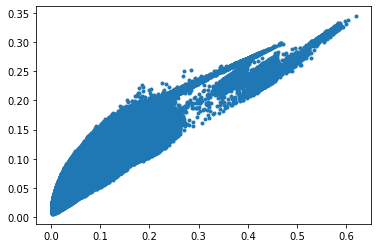

In [347]:
scatter_x = []
scatter_y = []
for i in range(nr_counties):
    scatter_x.extend(KS_mat[i, i+1:])
    scatter_y.extend(JS_mat[i, i+1:])

fig, ax = plt.subplots(1)
ax.scatter(scatter_x, scatter_y, marker='.')
fig.show()

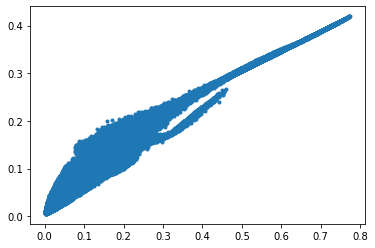

In [53]:
scatter_x = []
scatter_y = []
for i in range(nr_counties):
    scatter_x.extend(KS_mat[i, i+1:])
    scatter_y.extend(JS_mat[i, i+1:])
        
fig, ax = plt.subplots(1)
ax.scatter(scatter_x, scatter_y, marker='.')
fig.show()

### Infomap

pb: relative amplitudes of weights, for 2 clusters of 2 nodes, you need x10 between intra and inter cluster links

In [16]:
im = Infomap()
for i, fips1 in enumerate(fips_list):
    for j, fips2 in enumerate(fips_list[i+1:]):
#         im.add_link(fips1, fips2, weight=1 - (KS_mat[i, j+i+1]-min_KS) / (max_KS-min_KS))
        im.add_link(fips1, fips2, weight=1 / KS_mat[i, j+i+1])

In [53]:
im.get_modules(depth_level=5)

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
len(im.get_modules())

3075

In [17]:
im.run()
print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

# print("Result")
# print("\n#node module")
# for node in im.tree:
#     if node.is_leaf:
#         print(node.node_id, node.module_id)

Found 1 modules with codelength: 11.56414731008627


In [15]:
print("Result")
print("\n#node module")
for node in im.tree:
    if node.is_leaf:
        print(node.node_id, node.module_id)

Result

#node module
37157 1
6101 1
37191 1
37163 1
53021 1
51149 1
45043 1
48375 1
45055 1
48223 1
40083 1
45057 1
13127 1
1121 1
20125 1
54003 1
4003 1
45021 1
13295 1
1033 1
48005 1
20061 1
1051 1
29097 1
6115 1
12023 1
37159 1
24015 1
51047 1
48291 1
12111 1
6103 1
1001 1
45073 1
48349 1
5059 1
34009 1
35015 1
1017 1
37057 1
22001 1
4015 1
28059 1
28081 1
35005 1
29169 1
48055 1
24035 1
26149 1
5019 1
35045 1
13279 1
18091 1
37125 1
48475 1
37045 1
54033 1
45003 1
17115 1
48217 1
37141 1
21071 1
45031 1
37105 1
53007 1
24041 1
39161 1
21177 1
48325 1
13073 1
20057 1
37161 1
13175 1
54037 1
13297 1
1127 1
47115 1
47147 1
5131 1
37127 1
45035 1
51143 1
40071 1
48449 1
48481 1
48401 1
12035 1
12089 1
35029 1
45047 1
51650 1
37107 1
47053 1
42035 1
13179 1
21179 1
24009 1
13013 1
37069 1
48227 1
22105 1
13313 1
40019 1
13029 1
37019 1
37195 1
27141 1
1071 1
40015 1
37167 1
13103 1
20035 1
48189 1
51073 1
21013 1
51053 1
6021 1
35025 1
47123 1
21115 1
22005 1
37023 1
51109 1
13113 1
510

In [23]:
im.network.writePajekNetwork('ks_net.net')

### Louvain

In [70]:
G = nx.read_gpickle(processed_data_path / 'counties_ks_normed.net.gpickle.gz')

In [71]:
louvain_partition = community.best_partition(G)

In [72]:
louvain_partition = pd.Series(louvain_partition).rename('louvain')
louvain_partition.index = louvain_partition.index.astype(int)
county_partition_df = us_counties[['geometry']].join(louvain_partition, how='inner')

Normed KS net

<AxesSubplot:>

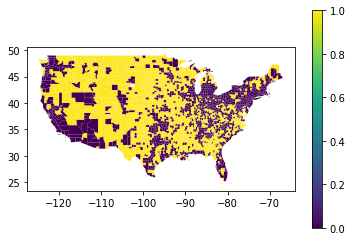

In [76]:
county_partition_df.plot(column='louvain', legend=True)

Take out urban cluster, see if rural ones make a distinction

In [91]:
nodes_to_rmv = louvain_partition.loc[louvain_partition == 0].index.values

In [92]:
sub_G = G.copy()
sub_G.remove_nodes_from(nodes_to_rmv)

In [93]:
louvain_sub_partition = community.best_partition(sub_G)

<AxesSubplot:>

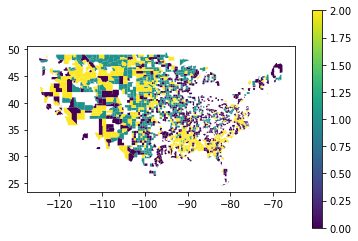

In [94]:
louvain_sub_partition = pd.Series(louvain_sub_partition).rename('louvain')
louvain_sub_partition.index = louvain_sub_partition.index.astype(int)
county_sub_partition_df = us_counties[['geometry']].join(louvain_sub_partition, how='inner')
county_sub_partition_df.plot(column='louvain', legend=True)

<AxesSubplot:>

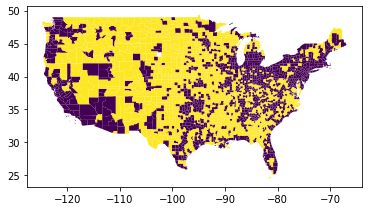

In [108]:
county_partition_df.plot(column='louvain')

Correlated with density map, to number of words in distrib too? Nope, doesn't look like it

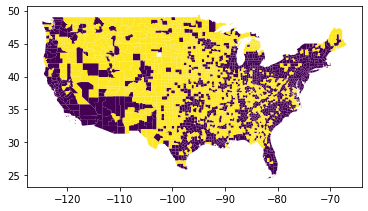

In [71]:
words_by_county = np.zeros(nr_counties)
for i, cnt_dict in enumerate(counties_dict.values()):
    words_by_county[i] = cnt_dict['word_counts'].shape[0]
words_by_county = np.log(words_by_county.reshape(-1, 1))
model = sklearn.cluster.KMeans(n_clusters=2).fit(words_by_county)
cluster_dict = {fips: cluster for fips, cluster in zip(fips_list, model.labels_)}
county_partition_df = us_counties[['geometry']].join(pd.Series(cluster_dict, name='hierarc'), how='inner')
zero_mask = county_partition_df['hierarc'] == 0
county_partition_df.loc[zero_mask, 'hierarc'] = 1
county_partition_df.loc[~zero_mask, 'hierarc'] = 0
county_partition_df.plot(column='hierarc')

JS net

<AxesSubplot:>

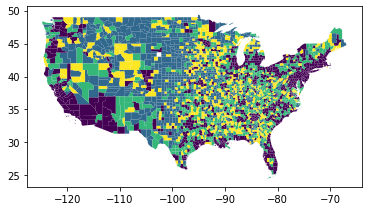

In [101]:
county_partition_df.plot(column='louvain')

KS net

<AxesSubplot:>

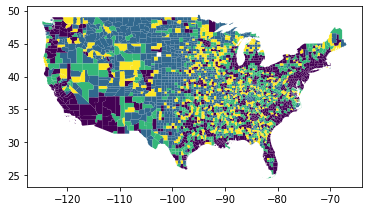

In [97]:
county_partition_df.plot(column='louvain')

### Hierarchical

In [23]:
all_vars = []
all_cells_clusters = []
all_clusters_centers = []
dist_mat = KS_mat.copy()

def get_hierarc(dist_mat, n_clusters, linkage):
    model = sklearn.cluster.AgglomerativeClustering(
        n_clusters=n_clusters, affinity='precomputed', linkage=linkage).fit(dist_mat)
    return model

model = get_hierarc(dist_mat, 5, 'average') 

<AxesSubplot:>

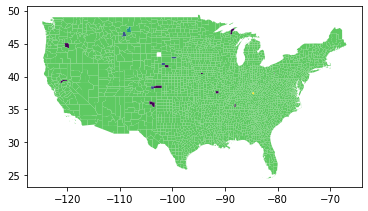

In [24]:
hierarc_dict = {fips: cluster for fips, cluster in zip(fips_list, model.labels_)}
county_partition_df = us_counties[['geometry']].join(pd.Series(hierarc_dict, name='hierarc'), how='inner')
county_partition_df.plot(column='hierarc')

In [180]:
all_vars = []
all_cells_clusters = []
all_clusters_centers = []
dist_mat = KS_mat.copy()
def get_hierarc(dist_mat, n_clusters, linkage):
    model = sklearn.cluster.AgglomerativeClustering(
        n_clusters=n_clusters, affinity='precomputed', linkage=linkage).fit(dist_mat)
    return model

model = get_hierarc(dist_mat, 5, 'average') 

<AxesSubplot:>

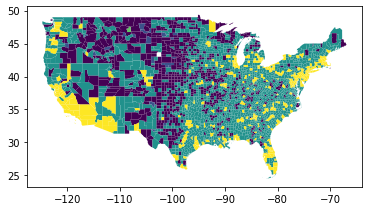

In [154]:
hierarc_dict = {fips: cluster for fips, cluster in zip(fips_list, model.labels_)}
county_partition_df = us_counties[['geometry']].join(pd.Series(hierarc_dict, name='hierarc'), how='inner')
county_partition_df.plot(column='hierarc')

# Zipf

Cleaning numbers and words with at least once a character repeated >3 times doesn't change anything

## Frequency distrib

In [29]:
from scipy.stats import linregress

Log binning pointless here because ranking are by definition unique and monotonically increasing. Thus here instead of log binning can just approximate by line going through the geometric mean of each plateau

California counties having way higher scaling: not because there is Spanish?? Does not seem like it

In [54]:
scaling_list = []
rvalue_list = []
for fips, cnt_dict in counties_dict.items():
    freq_distrib = cnt_dict['freq_distrib']
    bin_centers, bin_counts = data_bin.logbin(freq_distrib.values, freq_distrib.index.values, scale=1.8)
    not_zero = bin_counts > 0
    scaling, norm, rvalue, _, _ = linregress(np.log(bin_centers[not_zero]),
                                             np.log(bin_counts[not_zero]))
    scaling_list.append(scaling)
    rvalue_list.append(rvalue)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdd6775d050>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdd67758850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdd6775dd50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdd67755cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdd67755210>],
 'means': []}

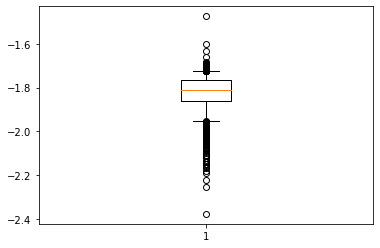

In [66]:
plt.boxplot(scaling_list, whis=(5,95))

/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$0.71 \times r^{-1.89}$ 0.9952944329706965
$0.69 \times r^{-1.71}$ 0.9951088351444274
$0.70 \times r^{-2.01}$ 0.991951654525786


/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$0.70 \times r^{-1.74}$ 0.9953756658165424
$0.76 \times r^{-1.78}$ 0.9957955059230685


/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$0.55 \times r^{-1.71}$ 0.996488682888314


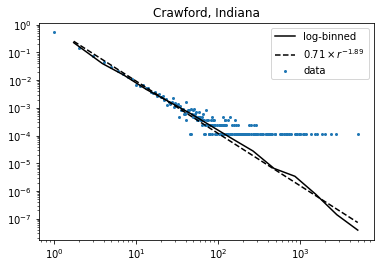

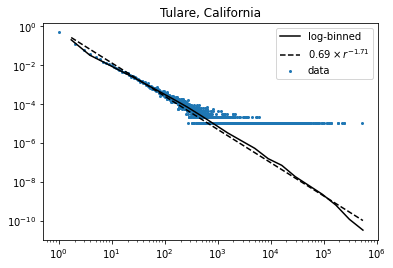

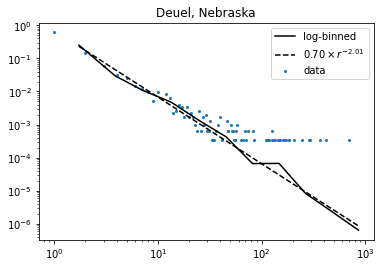

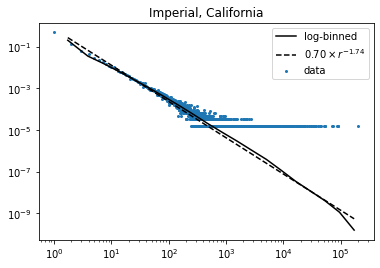

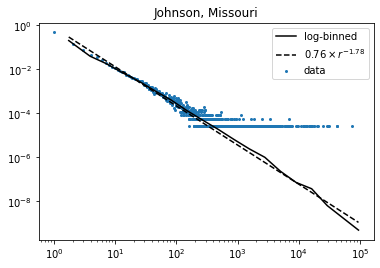

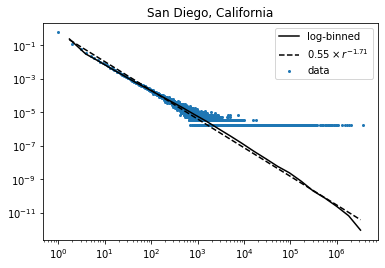

In [68]:
counties = (('Crawford', 'Indiana'), ('Tulare', 'California'),
            ('Deuel', 'Nebraska'), ('Imperial', 'California'),
            ('Johnson', 'Missouri'), ('San Diego', 'California'),)
for cnt, state in counties:
    fips = us_counties.loc[(us_counties['NAME'] == cnt) & (us_counties['NAME_STATE'] == state)].index[0]
    word_counts = pd.read_table(str(freq_file_format).format(fips), names=['word', 'count'])
    word_counts = word_counts.loc[word_counts['word'].notnull()]
    not_word = word_counts['word'].str.contains(r'(?:(\w)\1{2,}|[0-9])')
    word_counts = word_counts.loc[~not_word]
    freq_distrib = word_counts.groupby('count').nunique()['word'].rename('freq')
    freq_distrib /= freq_distrib.sum()
#     freq_distrib /= freq_distrib.sum()

    fig, ax = plt.subplots(1)
    ax.scatter(freq_distrib.index, freq_distrib.values, label='data', alpha=1, s=4)
    x, y = data_bin.logbin(freq_distrib.values, freq_distrib.index.values, scale=1.8)
    ax.plot(x, y, c='k', ls='-', label='log-binned')
#     mask = cnt_ranks > 0
    scaling, norm, rvalue, _, _ = linregress(np.log(x),
                                             np.log(y))
    approx_pdf = r'${:.2f} \times n^{{{:.2f}}}$'.format(np.exp(norm), scaling)
    print(approx_pdf, rvalue**2)

    ax.plot(x, np.exp(norm + scaling*np.log(x)), ls='--', c='k',
            label=approx_pdf)
    ax.set_title(f'{cnt}, {state}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    fig.show()

## Rank distrib

/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$0.30 \times r^{-1.17}$ 0.969964343424266
$3.35 \times r^{-1.53}$ 0.9721610086091873
$0.11 \times r^{-0.97}$ 0.9487771446605887


/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$2.26 \times r^{-1.47}$ 0.9753796111728101
$1.73 \times r^{-1.43}$ 0.9784469484759112


/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/thomaslouf/Documents/code/words-use/.venv/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


$0.53 \times r^{-1.35}$ 0.9464761114216769


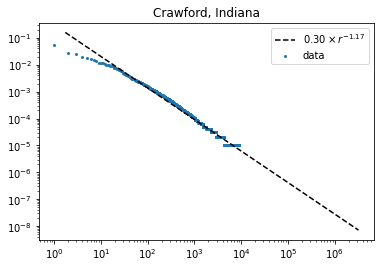

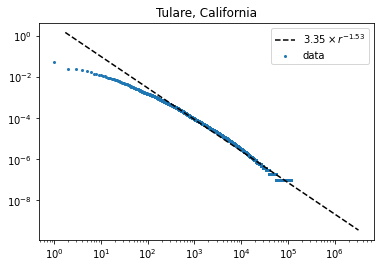

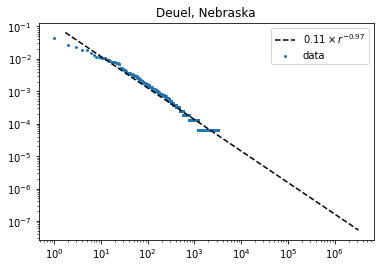

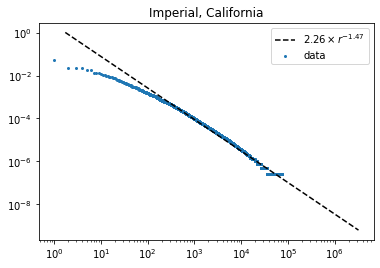

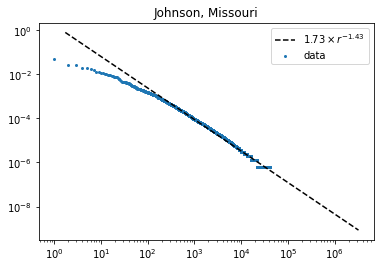

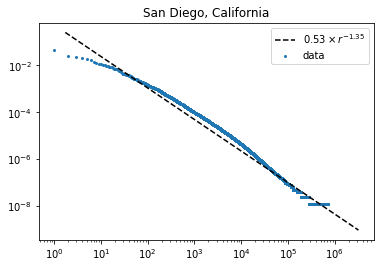

In [69]:
counties = (('Crawford', 'Indiana'), ('Tulare', 'California'),
            ('Deuel', 'Nebraska'), ('Imperial', 'California'),
            ('Johnson', 'Missouri'), ('San Diego', 'California'),)
for cnt, state in counties:
    fips = us_counties.loc[(us_counties['NAME'] == cnt) & (us_counties['NAME_STATE'] == state)].index[0]
    word_counts = pd.read_table(str(freq_file_format).format(fips), names=['word', 'count'])
    word_counts = word_counts.loc[word_counts['word'].notnull()]
    not_word = word_counts['word'].str.contains(r'(?:(\w)\1{2,}|[0-9])')
    word_counts = word_counts.loc[~not_word]
    word_counts['freq'] = word_counts['count'] / word_counts['count'].sum()
    
    fig, ax = plt.subplots(1)
    ax.scatter(word_counts.index+1, word_counts['freq'].values, label='data', alpha=1, s=4)
#     mask = cnt_ranks > 0
    scaling, norm, rvalue, _, _ = linregress(np.log(word_counts.index+1),
                                             np.log(word_counts['freq'].values))
    approx_pdf = r'${:.2f} \times r^{{{:.2f}}}$'.format(np.exp(norm), scaling)
    print(approx_pdf, rvalue**2)

    ax.plot(x, np.exp(norm + scaling*np.log(x)), ls='--', c='k',
            label=approx_pdf)
    ax.set_title(f'{cnt}, {state}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    fig.show()

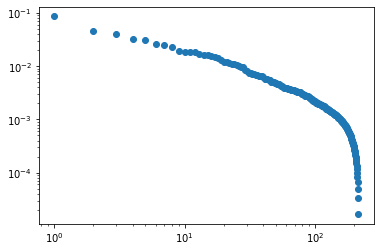

In [39]:
cnt_dict = counties_dict[18025]
fig, ax = plt.subplots(1)
cnt_distrib = cnt_dict['grp_rank_counts']
cnt_ranks = np.array(range(len(cnt_distrib))) + 1
ax.scatter(cnt_ranks, cnt_distrib)
ax.set_xscale('log')
ax.set_yscale('log')
fig.show()

In [18]:
word_counts = pd.read_table(str(freq_file_format).format(29001), names=['word', 'count'])

Number of words by count:

In [21]:
grp_rank_counts = word_counts['count'].unique()

Log normalize ranking? like 0 to 1, correspondig to 10^0 and 10^max

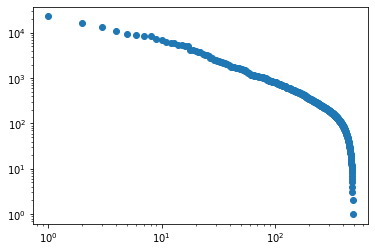

In [22]:
min_count_mask = grp_rank_counts > 0
ranks = np.array(range(len(grp_rank_counts[min_count_mask]))) + 1
log_ranks = np.log(ranks)
log_ranks = log_ranks / np.max(log_ranks)
fig, ax = plt.subplots(1)
ax.scatter(ranks, grp_rank_counts[min_count_mask])
ax.set_xscale('log')
ax.set_yscale('log')
fig.show()